In [1]:
pip install unicodecsv networkx pandas numpy tensorflow scikit-learn matplotli seaborn geopy tqdm

ERROR: Could not find a version that satisfies the requirement matplotli (from versions: none)
ERROR: No matching distribution found for matplotli

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import networkx as nx
import pandas as pd
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os  ##跟工作路径相关的包
import matplotlib.pyplot as plt  ##画图的包
import unicodecsv as csv  ##写入EXCEL文件的包
import numpy as np  ##数据处理包
import pandas as pd  ##数据处理包
import scipy.stats as ss  ## 统计函数的包
from networkx.algorithms import community  ##社区分析的专用函数

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [4]:
# land in
friendship_df = pd.read_csv("/Users/wangbaiyi/Desktop/private life/大四下/毕业论文/loc-brightkite_edges.txt", sep="\t", header=None, names=["user1", "user2"])
checkin_df = pd.read_csv("/Users/wangbaiyi/Desktop/private life/大四下/毕业论文/loc-brightkite_totalCheckins.txt", sep="\t", header=None, names=["user", "checkin_time", "latitude", "longitude", "location_id"])
checkin_df

,user,checkin_time,latitude,longitude,location_id
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5
1,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
2,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
3,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
4,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc
...,...,...,...,...,...
4747282,58222,2009-01-23T02:30:34Z,33.833333,35.833333,9f6b83bca22411dd85460384f67fcdb0
4747283,58224,2009-01-03T15:06:54Z,33.833333,35.833333,9f6b83bca22411dd85460384f67fcdb0
4747284,58225,2009-01-20T13:58:14Z,33.833333,35.833333,9f6b83bca22411dd85460384f67fcdb0
4747285,58226,2009-01-20T13:30:09Z,33.833333,35.833333,9f6b83bca22411dd85460384f67fcdb0


In [5]:
friendship_df

,user1,user2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
428151,58225,58226
428152,58225,58227
428153,58226,58220
428154,58226,58225


洗数据

In [6]:
#过滤缺失值和异常数据
# 统计缺失值
missing_coords = checkin_df["latitude"].isna().sum() + checkin_df["longitude"].isna().sum()

# 统计非法纬度（不在 -90 到 90）
invalid_lat = checkin_df[~checkin_df["latitude"].between(-90, 90)].shape[0]

# 统计非法经度（不在 -180 到 180）
invalid_lon = checkin_df[~checkin_df["longitude"].between(-180, 180)].shape[0]

print(f"缺失经纬度记录数: {missing_coords}")
print(f"非法纬度记录数: {invalid_lat}")
print(f"非法经度记录数: {invalid_lon}")

缺失经纬度记录数: 12
非法纬度记录数: 115
非法经度记录数: 6


In [7]:
# 删除缺失
missing_per_column = checkin_df.isna().sum()
print("每列缺失值数量：")
print(missing_per_column)


每列缺失值数量：
user            0
checkin_time    6
latitude        6
longitude       6
location_id     6
dtype: int64


In [8]:
checkin_df_cleaned = checkin_df.dropna()
print(f"清洗后剩余的记录数：{len(checkin_df_cleaned)}")

清洗后剩余的记录数：4747281


In [9]:
# 统计非法纬度（不在 -90 到 90）
invalid_lat = checkin_df[~checkin_df["latitude"].between(-90, 90)].shape[0]

# 统计非法经度（不在 -180 到 180）
invalid_lon = checkin_df[~checkin_df["longitude"].between(-180, 180)].shape[0]
print(f"非法纬度记录数: {invalid_lat}")
print(f"非法经度记录数: {invalid_lon}")

非法纬度记录数: 115
非法经度记录数: 6


In [10]:
# 删除缺失和非法经纬度的记录
checkin_df = checkin_df.dropna(subset=["latitude", "longitude"])
checkin_df = checkin_df_cleaned[
    (checkin_df["latitude"].between(-90, 90)) & 
    (checkin_df["longitude"].between(-180, 180))
]

# 清洗后保留的记录数
print(f"清洗后剩余记录数: {checkin_df.shape[0]}")

清洗后剩余记录数: 4747172


In [11]:
print(f"重复行数: {checkin_df.duplicated().sum()}")

重复行数: 44546


In [12]:
# 删除完全重复的行
checkin_df = checkin_df.drop_duplicates()

print(f"去重后记录数: {len(checkin_df)}")

去重后记录数: 4702626


In [13]:
print("总记录数:", len(checkin_df))

print("不同用户数:", checkin_df['user'].nunique())
print("不同地点数:", checkin_df['location_id'].nunique())
print("不同用户-时间组合数:", checkin_df.groupby(['user', 'checkin_time']).size().shape[0])
print("不同用户-地点组合数:", checkin_df.groupby(['user', 'location_id']).size().shape[0])
print("不同用户-时间-地点组合数:", checkin_df.groupby(['user', 'checkin_time', 'location_id']).size().shape[0])


总记录数: 4702626
不同用户数: 51406
不同地点数: 772961
不同用户-时间组合数: 4701962
不同用户-地点组合数: 1076164
不同用户-时间-地点组合数: 4702626


In [30]:
checkin_df

,user,checkin_time,latitude,longitude,location_id
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5
1,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
2,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
3,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
4,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc
...,...,...,...,...,...
4747282,58222,2009-01-23T02:30:34Z,33.833333,35.833333,9f6b83bca22411dd85460384f67fcdb0
4747283,58224,2009-01-03T15:06:54Z,33.833333,35.833333,9f6b83bca22411dd85460384f67fcdb0
4747284,58225,2009-01-20T13:58:14Z,33.833333,35.833333,9f6b83bca22411dd85460384f67fcdb0
4747285,58226,2009-01-20T13:30:09Z,33.833333,35.833333,9f6b83bca22411dd85460384f67fcdb0


In [14]:
# Build the graph
graph = nx.Graph()
for _, row in friendship_df.iterrows():
    graph.add_edge(row['user1'], row['user2'])

In [15]:
# Add node features based on check-ins
checkin_data = checkin_df.copy()
checkin_data['checkin_time'] = pd.to_datetime(checkin_data['checkin_time'])

In [16]:
# Aggregate check-in features
user_features = (
    checkin_data.groupby('user').agg(
        checkin_count=('location_id', 'count'),
        unique_locations=('location_id', 'nunique')
    ).reset_index()
)

In [17]:
# Normalize features
scaler = StandardScaler()
user_features[['checkin_count', 'unique_locations']] = scaler.fit_transform(user_features[['checkin_count', 'unique_locations']])

In [18]:
# Add features to nodes
for _, row in user_features.iterrows():
    graph.nodes[row['user']]["features"] = [row['checkin_count'], row['unique_locations']]

网络可视化

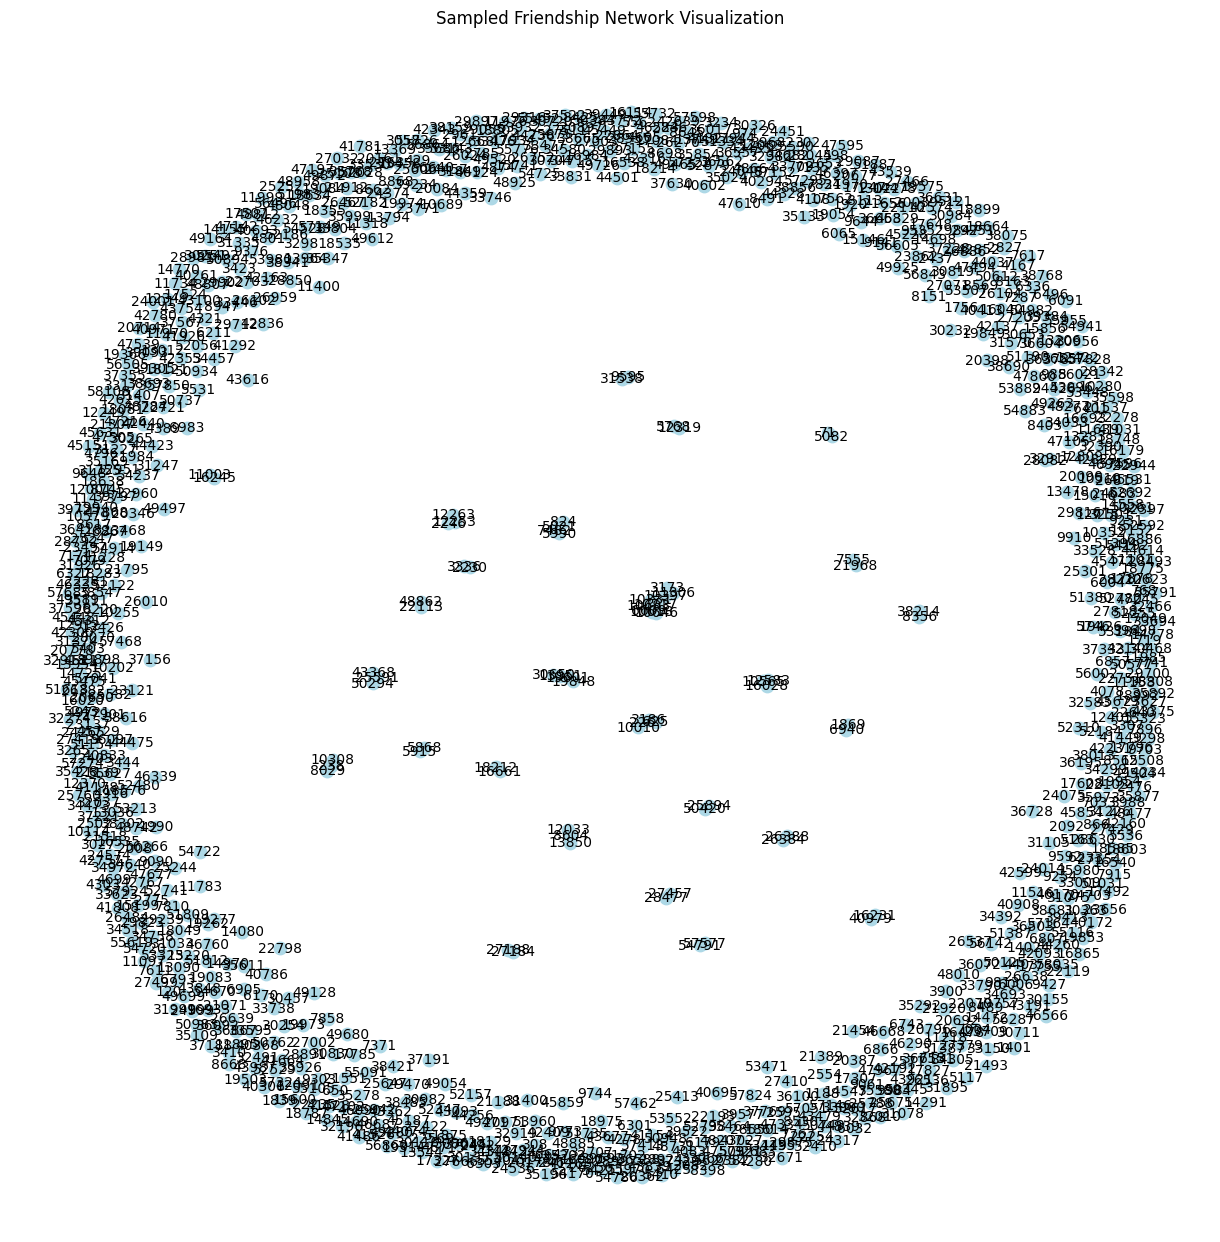

In [19]:
# Step 2: Convert to NetworkX graph
friendlink = nx.from_pandas_edgelist(friendship_df, "user1", "user2")

# Step 3: Random sampling for visualization
# Sample 1000 nodes for simplicity
sampled_nodes = np.random.choice(friendlink.nodes(), size=min(1000, len(friendlink.nodes())), replace=False)
sampled_graph = friendlink.subgraph(sampled_nodes)

# Compute positions for sampled graph
positions = nx.spring_layout(sampled_graph, seed=42)

# Draw the sampled graph
plt.figure(figsize=(12, 12))
nx.draw(
    sampled_graph,
    pos=positions,
    with_labels=True,
    node_color='lightblue',
    node_size=80,
    font_size=10
)
plt.title("Sampled Friendship Network Visualization")
plt.savefig("friendlink_graph_sampled.png")


In [20]:
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import modularity

In [21]:
# 使用贪婪模块度优化算法发现社区
communities = greedy_modularity_communities(sampled_graph)

# 计算模块度
qg = modularity(sampled_graph, communities)
print(f"模块度 (Modularity): {qg}")

# 输出社区划分
print(f"社区数量: {len(communities)}")
print("部分社区示例:")
for i, community in enumerate(list(communities)[:5]):  # 打印前 5 个社区
    print(f"社区 {i}: {list(community)}")

模块度 (Modularity): 0.9148968913511849
社区数量: 952
部分社区示例:
社区 0: [np.int64(6609), np.int64(10693), np.int64(10646), np.int64(10618), np.int64(10331), np.int64(10717)]
社区 1: [np.int64(824), np.int64(7482), np.int64(5021), np.int64(5990)]
社区 2: [np.int64(625), np.int64(3186), np.int64(226), np.int64(10010)]
社区 3: [np.int64(19848), np.int64(19601), np.int64(30650), np.int64(13951)]
社区 4: [np.int64(10308), np.int64(8029), np.int64(238)]


In [22]:
pos=nx.spring_layout(sampled_graph)#set position of each knots

In [23]:
#color patches
comm_clor = [
    '#A7A19E',  # 莫兰迪灰
    '#B5A89F',  # 莫兰迪棕
    '#D6CFC4',  # 莫兰迪米白
    '#D0B49F',  # 莫兰迪肉粉
    '#A49E9B',  # 莫兰迪灰褐
    '#D1D5D8',  # 莫兰迪浅灰蓝
    '#8F8C89',  # 莫兰迪深灰
    '#BFADA3',  # 莫兰迪奶茶
    '#CAB5A3',  # 莫兰迪浅棕粉
    '#8C8B85',  # 莫兰迪石灰
    '#ABA9A5',  # 莫兰迪青灰
    '#C3B6A6',  # 莫兰迪咖啡
    '#D5CBC2',  # 莫兰迪裸粉
    '#BCC0C4',  # 莫兰迪蓝灰
    '#B8C2CE',  # 莫兰迪水蓝
    '#97948F',  # 莫兰迪冷灰
    '#B4A99B',  # 莫兰迪烟灰
    '#D4C5B8',  # 莫兰迪奶杏
    '#BFC1C2',  # 莫兰迪银灰
    '#C7BAB1',  # 莫兰迪米驼
    '#A8A9AA',  # 莫兰迪淡银
]
# 如果现有颜色不足，自动生成更多颜色
if len(comm_clor) < len(communities):
    comm_clor = plt.cm.tab20.colors  # 使用 Matplotlib 的调色板生成颜色
    comm_clor = list(comm_clor) * (len(communities) // len(comm_clor) + 1)  # 重复颜色以匹配社区数量

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


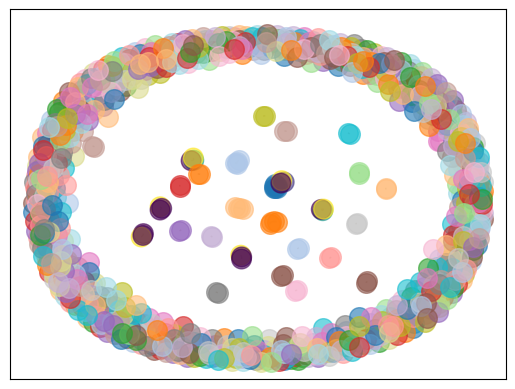

In [24]:
# 正确地画出边
nx.draw_networkx_edges(sampled_graph, pos=positions, edgelist=sampled_graph.edges(), width=1.0, edge_color='#D5CBC2')

# 然后再画出按 community 分类的节点
for i in range(len(communities)):
    nx.draw_networkx_nodes(
        sampled_graph,
        pos=positions,
        nodelist=communities[i],
        node_size=200,
        node_color=comm_clor[i],
        alpha=0.6
    )

In [25]:
import networkx as nx
import pandas as pd
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os  ##跟工作路径相关的包
import matplotlib.pyplot as plt  ##画图的包
import unicodecsv as csv  ##写入EXCEL文件的包
import numpy as np  ##数据处理包
import pandas as pd  ##数据处理包
import scipy.stats as ss  ## 统计函数的包
from networkx.algorithms import community  ##社区分析的专用函数

In [26]:
print("图的节点数:", sampled_graph.number_of_nodes())
print("图的边数:", sampled_graph.number_of_edges())

图的节点数: 1000
图的边数: 57


In [29]:
print(type(sampled_nodes))  # 检查数据类型
print(sampled_nodes.shape)  # 检查数据形状

<class 'numpy.ndarray'>
(1000,)


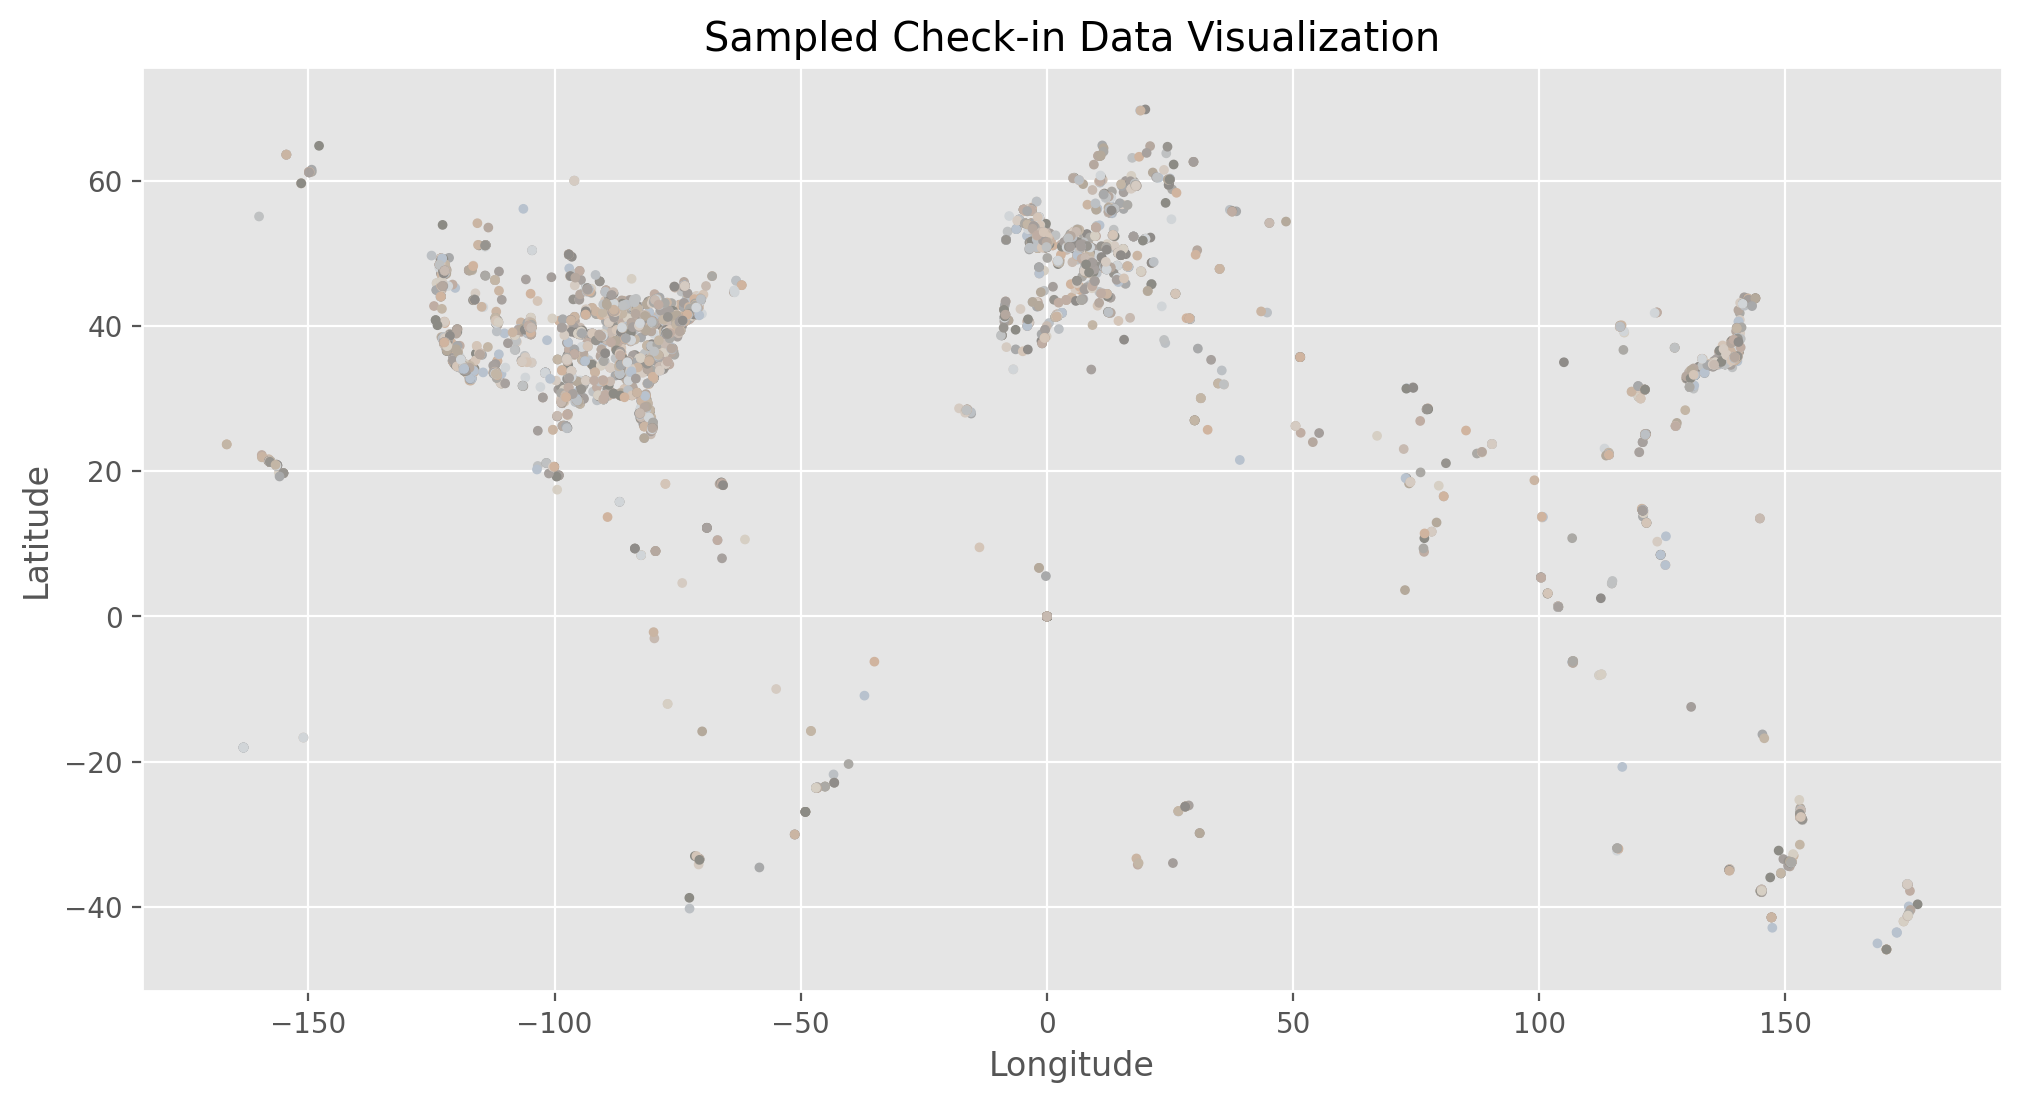

In [32]:
# Step 4: Visualize Check-in Data with Sampling
# 将 numpy.ndarray 转换为 pandas.DataFrame
checkin_df = pd.DataFrame(checkin_df)
# 现在可以使用 sample 方法
checkin_sample = checkin_df.sample(n=min(10000, len(checkin_df)), random_state=42)
x_data = checkin_sample['longitude'].values
y_data = checkin_sample['latitude'].values

# Generate random colors for visualization
colors = np.random.choice([
    '#A7A19E',  # Morandi Gray
    '#B5A89F',  # Morandi Brown
    '#D6CFC4',  # Morandi Beige
    '#D0B49F',  # Morandi Pink
    '#A49E9B',  # Morandi Taupe
    '#D1D5D8',  # Morandi Light Blue
    '#8F8C89',  # Morandi Dark Gray
    '#BFADA3',  # Morandi Milk Tea
    '#CAB5A3',  # Morandi Light Brown Pink
    '#8C8B85',  # Morandi Lime
    '#ABA9A5',  # Morandi Green Gray
    '#C3B6A6',  # Morandi Coffee
    '#D5CBC2',  # Morandi Nude Pink
    '#BCC0C4',  # Morandi Blue Gray
    '#B8C2CE',  # Morandi Water Blue
    '#97948F',  # Morandi Cool Gray
    '#B4A99B',  # Morandi Smoky Gray
    '#D4C5B8',  # Morandi Apricot
    '#BFC1C2',  # Morandi Silver Gray
    '#C7BAB1',  # Morandi Camel
    '#A8A9AA',  # Morandi Pale Silver
], size=len(x_data))

# Scatter plot of sampled check-in data
plt.style.use('ggplot')
plt.figure(figsize=(12, 6), dpi=200)
plt.scatter(x_data, y_data, marker="o", s=9., c=colors)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Sampled Check-in Data Visualization")
plt.savefig("checkin_scatter_plot_sampled.png")